In [1]:
from google.colab import drive
drive.mount('/content/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!git clone https://github.com/eriklindernoren/PyTorch-YOLOv3.git
%cd PyTorch-YOLOv3
!sudo pip3 install -r requirements.txt
!bash weights/download_weights.sh
%cd config/
!bash create_custom_model.sh 6

%cd .. 



Cloning into 'PyTorch-YOLOv3'...
remote: Enumerating objects: 724, done.
remote: Total 724 (delta 0), reused 0 (delta 0), pack-reused 724
Receiving objects: 100% (724/724), 16.16 MiB | 44.26 MiB/s, done.
Resolving deltas: 100% (426/426), done.
/content/PyTorch-YOLOv3
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built terminaltables
--2019-06-14 20:42:47--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  1.63MB/s    in 58s     

2019-06-14 20:43:45 (4.08 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2019-06-14 20:43:45--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.co

In [0]:
import os
import sys
import tarfile
import collections
import torch
import matplotlib.image as mpimg
from PIL import Image
import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity
from torchvision import datasets
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
import argparse
from models import *
from torch.utils.data import DataLoader
from utils.logger import *
from utils.utils import *
from utils.datasets import *
from utils.parse_config import *
from terminaltables import AsciiTable
import datetime
# from test import evaluate #need to use own test file
from torch.autograd import Variable
from matplotlib.ticker import NullLocator
import tensorflow as tf

In [4]:
%cd .. 
%cd gdrive
%cd My Drive
from yolotest import evaluate
%cd ..
%cd ..


/content
/content/gdrive
/content/gdrive/My Drive
/content/gdrive
/content


In [5]:
%cd PyTorch-YOLOv3

/content/PyTorch-YOLOv3


In [6]:
%ls

assets/            detect.py     README.md         utils/
config/            LICENSE       requirements.txt  weights/
darknet53.conv.74  models.py     test.py           yolov3-tiny.weights
data/              __pycache__/  train.py          yolov3.weights


In [0]:
# data_dir_pic = '../gdrive/My Drive/dolphin_9.jpg'
# data_dir_txt = '../gdrive/My Drive/dolphin_9.txt'
# # img = mpimg.imread(data_dir_pic)
# img1 = Image.open(data_dir_pic)
# img = transform(img1)
def myimshow(image, ax=plt):
#     image = image.to('cpu').detach().numpy()
    image = np.moveaxis(image.numpy(), [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h
  
# imgplot = plt.imshow(img)
# myimshow(img)
# plt.imshow(img1)



In [0]:
# im = np.array(img)
# plt.figure()
# fig, ax = plt.subplots(1)
# ax.imshow(img1)
# bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor='green', facecolor="none")
# ax.add_patch(bbox)
# plt.show()  

def get_file(file_dir, num_data):
  data_list_array = np.zeros(num_data).reshape(1, num_data)
  with open(file_dir) as fp:  
    for cnt, line in enumerate(fp):
      num_list = []
      for i in line.split():
        num_list.append(float(i))
      num_list = np.array(num_list).reshape(1, num_data)
      data_list_array = np.concatenate((data_list_array, num_list), axis=0)
    data_list_array = np.delete(data_list_array, 0, 0)
    
  return data_list_array




In [0]:
class YOLODataset(Dataset):
  def __init__(self, list_path, img_size=416, augment=True, multiscale=True, normalized_labels=True):
    with open(list_path, "r") as file:
      self.img_files = file.readlines()
    self.label_files = [
            path.replace("images", "labels").replace(".png", ".txt").replace(".jpg", ".txt")
            for path in self.img_files
        ]

    self.img_size = img_size
    self.max_objects = 100
#    self.augment = augment
#    self.multiscale = multiscale
    self.normalized_labels = normalized_labels
#    self.min_size = self.img_size - 3 * 32
#    self.max_size = self.img_size + 3 * 32
#    self.batch_count = 0
    
  def __getitem__(self, index):

    # ---------
    #  Image
    # ---------

    img_path = self.img_files[index % len(self.img_files)].rstrip()

    # Extract image as PyTorch tensor
    img = transforms.ToTensor()(Image.open(img_path).convert('RGB'))

#     # Handle images with less than three channels
#     if len(img.shape) != 3:
#         img = img.unsqueeze(0)
#         img = img.expand((3, img.shape[1:]))

    _, h, w = img.shape
    h_factor, w_factor = (h, w) if self.normalized_labels else (1, 1)
    # Pad to square resolution
#     img, pad = pad_to_square(img, 0)
#     img_pil = tv.transforms.ToPILImage()
#     transform = tv.transforms.Compose([
#     tv.transforms.Resize((img_size, img_size)),
#     tv.transforms.ToTensor(),
# #     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
#     ])
#     x = transform(img_pil(img))
    _, padded_h, padded_w = img.shape

    # ---------
    #  Label
    # ---------

    label_path = self.label_files[index % len(self.img_files)].rstrip()

    targets = None
    if os.path.exists(label_path):
        boxes = torch.from_numpy(np.loadtxt(label_path).reshape(-1, 5))
        # Extract coordinates for unpadded + unscaled image
#         x1 = w_factor * (boxes[:, 1] - boxes[:, 3] / 2)
#         y1 = h_factor * (boxes[:, 2] - boxes[:, 4] / 2)
#         x2 = w_factor * (boxes[:, 1] + boxes[:, 3] / 2)
#         y2 = h_factor * (boxes[:, 2] + boxes[:, 4] / 2)
#         # Adjust for added padding
#         x1 += pad[0]
#         y1 += pad[2]
#         x2 += pad[1]
#         y2 += pad[3]
#         # Returns (x, y, w, h)
#         boxes[:, 1] = ((x1 + x2) / 2) / padded_w
#         boxes[:, 2] = ((y1 + y2) / 2) / padded_h
# #         boxes[:, 1] = (x1 + x2) / 2
# #         boxes[:, 2] = (y1 + y2) / 2
# #         boxes[:, 3] = x2 - x1
# #         boxes[:, 4] = y2 - y1
#         boxes[:, 3] *= w_factor / padded_w
#         boxes[:, 4] *= h_factor / padded_h

        targets = torch.zeros((len(boxes), 6))
        targets[:, 1:] = boxes

#     # Apply augmentations
#     if self.augment:
#         if np.random.random() < 0.5:
#             img, targets = horisontal_flip(img, targets)
    
    return img, targets
  
  def collate_fn(self, batch):
    
      imgs, targets = list(zip(*batch))
      # Remove empty placeholder targets
      targets = [boxes for boxes in targets if boxes is not None]
      # Add sample index to targets
      for i, boxes in enumerate(targets):
          boxes[:, 0] = i
      targets = torch.cat(targets, 0)
#       # Selects new image size every tenth batch
#       if self.multiscale and self.batch_count % 10 == 0:
#           self.img_size = random.choice(range(self.min_size, self.max_size + 1, 32))
      # Resize images to input shape
      imgs = torch.stack([resize(img, self.img_size) for img in imgs])
      self.batch_count += 1
      return imgs, targets
    
  def __len__(self):
      return len(self.img_files)

In [0]:
train_list_path = '../gdrive/My Drive/train_marine.txt'
val_list_path =  '../gdrive/My Drive/val_marine.txt'

dataset = YOLODataset(train_list_path)
valset = YOLODataset(val_list_path)


277
888
tensor([[0.0000, 0.0000, 0.1662, 0.5101, 0.1015, 0.1509],
        [0.0000, 0.0000, 0.2581, 0.4420, 0.1285, 0.1430],
        [0.0000, 0.0000, 0.4538, 0.4245, 0.3092, 0.2005],
        [0.0000, 0.0000, 0.7419, 0.4206, 0.2469, 0.1948],
        [0.0000, 0.0000, 0.6450, 0.6211, 0.3054, 0.2646],
        [0.0000, 0.0000, 0.8869, 0.7111, 0.1938, 0.3525],
        [0.0000, 0.0000, 0.4062, 0.6166, 0.2877, 0.1813]])


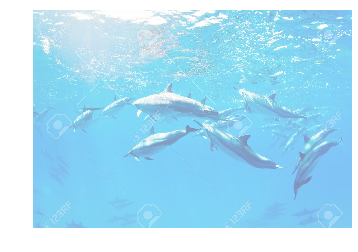

In [93]:
xz, yz = valset[9]

myimshow(xz)

print(len(dataset))

print(xz.numpy().shape[1])

print(yz)

In [12]:
object_to_idx = {'dolphin': 0,'fish': 1,'turtle': 2,'jellyfish': 3,
              'starfish': 4,'swordfish': 5}


class_names = list(object_to_idx.keys())
print(class_names)


['dolphin', 'fish', 'turtle', 'jellyfish', 'starfish', 'swordfish']


In [79]:
Argument_Dict = {}
Argument_Dict['epochs'] = 200
Argument_Dict['batch_size'] = 8
Argument_Dict['model_def'] = 'config/yolov3-custom.cfg'
Argument_Dict['pretrain_weights'] = 'From Now Start'
Argument_Dict['pretrain_weights'] = 'checkpoints/yolov3_cp_1.pth' #train start
Argument_Dict['pretrain_weights'] = 'checkpoints/yolov3_cp_50.pth' #test
#59 mAP is 0.55
Argument_Dict['yolov3_weights'] = 'yolov3.weights'
Argument_Dict['n_cpu'] = 8
Argument_Dict['gradient_accumulations'] = 2
Argument_Dict['evaluation_interval'] = 1
Argument_Dict['checkpoint_interval'] = 1
Argument_Dict['img_size'] = 416
Argument_Dict['conf_thres'] = 0.8 #object confidence threshold
Argument_Dict['nms_thres'] = 0.4 #iou thresshold for non-maximum suppression"

print(Argument_Dict)


{'epochs': 200, 'batch_size': 8, 'model_def': 'config/yolov3-custom.cfg', 'pretrain_weights': 'checkpoints/yolov3_cp_50.pth', 'yolov3_weights': 'yolov3.weights', 'n_cpu': 8, 'gradient_accumulations': 2, 'evaluation_interval': 1, 'checkpoint_interval': 1, 'img_size': 416, 'conf_thres': 0.8, 'nms_thres': 0.4}


In [14]:
logger = Logger("logs")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)


W0614 20:47:34.764198 140250257909632 deprecation_wrapper.py:119] From /content/PyTorch-YOLOv3/utils/logger.py:7: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



cuda


In [15]:
model = Darknet(Argument_Dict['model_def']).to(device)
model.apply(weights_init_normal)


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [16]:
if Argument_Dict['pretrain_weights']:
    if Argument_Dict['pretrain_weights'].endswith(".pth"):
      model.load_state_dict(torch.load(Argument_Dict['pretrain_weights']))
      print('load state dict')
    else:
      model.load_darknet_weights(Argument_Dict['yolov3_weights'])
      print('load darknet weights')

    

load darknet weights


In [0]:
dataloader = torch.utils.data.DataLoader(
    dataset = dataset,
    batch_size= Argument_Dict['batch_size'],
    num_workers= Argument_Dict['n_cpu'],
    pin_memory= True,
    drop_last = True,
    shuffle = True,
    collate_fn= dataset.collate_fn,
)

# mini_batch = []
# mini_label = []
# for batch_i, (local_batch, local_label) in enumerate(dataloader):
#     mini_batch.append(local_batch)
#     mini_label.append(local_label)

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

metrics = [
    "grid_size",
    "loss",
    "x",
    "y",
    "w",
    "h",
    "conf",
    "cls",
    "cls_acc",
    "recall50",
    "recall75",
    "precision",
    "conf_obj",
    "conf_noobj",
]



In [21]:
#important !!!
#create files to save parameters only run once
save_loss_path = '../gdrive/My Drive/loss_listnew.npy'
save_map_path = '../gdrive/My Drive/map_listnew.npy'
save_precision_path = '../gdrive/My Drive/precision_listnew.npy'
if not os.path.exists(save_loss_path):
    loss_list = []
    np.save(save_loss_path, loss_list)
    print(1)
if not os.path.exists(save_map_path):
    map_list = []
    np.save(save_map_path, map_list)
    print(2)
if not os.path.exists(save_precision_path):    
    precision_list = []
    np.save(save_precision_path, precision_list)
    print(3)

1
2
3


In [32]:
for epoch in range(1,Argument_Dict['epochs']):
    model.train()
    start_time = time.time()
    for batch_i, (imgs, targets) in enumerate(dataloader):
        batches_done = len(dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
#         print(imgs.cpu().numpy().shape)
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()

        if batches_done % Argument_Dict['gradient_accumulations']:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()

        # ----------------
        #   Log progress
        # ----------------

#         log_str = "\n---- [Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, Argument_Dict['epochs'], batch_i, len(dataloader))

#         metric_table = [["Metrics", *[f"YOLO Layer {i}" for i in range(len(model.yolo_layers))]]]

#         # Log metrics at each YOLO layer
#         for i, metric in enumerate(metrics):
#             formats = {m: "%.6f" for m in metrics}
#             formats["grid_size"] = "%2d"
#             formats["cls_acc"] = "%.2f%%"
#             row_metrics = [formats[metric] % yolo.metrics.get(metric, 0) for yolo in model.yolo_layers]
#             metric_table += [[metric, *row_metrics]]

#             # Tensorboard logging
#             tensorboard_log = []
#             for j, yolo in enumerate(model.yolo_layers):
#                 for name, metric in yolo.metrics.items():
#                     if name != "grid_size":
#                         tensorboard_log += [(f"{name}_{j+1}", metric)]
#             tensorboard_log += [("loss", loss.item())]
#             logger.list_of_scalars_summary(tensorboard_log, batches_done)

#         log_str += AsciiTable(metric_table).table
#         log_str += f"\nTotal loss {loss.item()}"

#         # Determine approximate time left for epoch
# #         epoch_batches_left = len(dataloader) - (batch_i + 1)
# #         time_left = datetime.timedelta(seconds=epoch_batches_left * (time.time() - start_time) / (batch_i + 1))
# #         log_str += f"\n---- ETA {time_left}"

#         print(log_str)

#         model.seen += imgs.size(0)

    if epoch % Argument_Dict['evaluation_interval'] == 0:
        log_str = "\n---- [Epoch %d/%d] ----\n" % (epoch, Argument_Dict['epochs'])
        log_str += f"\nTotal loss {loss.item()}"
        print(log_str)
        
        print("\n---- Evaluating Model ----")
        # Evaluate the model on the validation set
        precision, recall, AP, f1, ap_class = evaluate(
            model,
            dataset=valset, 
            iou_thres=0.5,
            conf_thres=0.5,
            nms_thres=0.5,
            img_size=Argument_Dict['img_size'],
            batch_size=Argument_Dict['batch_size'],
        )
        evaluation_metrics = [
            ("val_precision", precision.mean()),
            ("val_recall", recall.mean()),
            ("val_mAP", AP.mean()),
            ("val_f1", f1.mean()),
        ]
        
        logger.list_of_scalars_summary(evaluation_metrics, epoch)

        # Print class APs and mAP
        ap_table = [["Index", "Class name", "AP"]]
        for i, c in enumerate(ap_class):
            ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
        print(AsciiTable(ap_table).table)
        print(f"---- mAP {AP.mean()}")
        
        
        old_loss = np.load(save_loss_path)
        old_loss = old_loss.tolist()
        old_loss.append(loss.item())
#         np.save(save_loss_path)
        np.save(save_loss_path, old_loss)
        
        old_map = np.load(save_map_path)
        old_map = old_map.tolist()
        old_map.append(AP.mean())
#         np.save(save_map_path)
        np.save(save_map_path, old_map)
        
        old_precision = np.load(save_precision_path)
        old_precision = old_precision.tolist()
        old_precision.append(precision.mean())
#         np.save(save_precision_path)
        np.save(save_precision_path, old_precision)

    if epoch % Argument_Dict['checkpoint_interval'] == 0:
        torch.save(model.state_dict(), f"checkpoints/yolov3_cp_%d.pth" % epoch)
        

Detecting objects:   0%|          | 0/10 [00:00<?, ?it/s]


---- [Epoch 1/200] ----

Total loss 1.1437658071517944

---- Evaluating Model ----


Computing AP: 100%|██████████| 6/6 [00:00<00:00, 2049.50it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | dolphin    | 1.00000 |
| 1     | fish       | 1.00000 |
| 2     | turtle     | 1.00000 |
| 3     | jellyfish  | 1.00000 |
| 4     | starfish   | 1.00000 |
| 5     | swordfish  | 1.00000 |
+-------+------------+---------+
---- mAP 1.0


Detecting objects:   0%|          | 0/10 [00:00<?, ?it/s]


---- [Epoch 2/200] ----

Total loss 0.9285100102424622

---- Evaluating Model ----


Computing AP: 100%|██████████| 6/6 [00:00<00:00, 2467.48it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | dolphin    | 1.00000 |
| 1     | fish       | 1.00000 |
| 2     | turtle     | 1.00000 |
| 3     | jellyfish  | 1.00000 |
| 4     | starfish   | 1.00000 |
| 5     | swordfish  | 1.00000 |
+-------+------------+---------+
---- mAP 1.0


Detecting objects:   0%|          | 0/10 [00:00<?, ?it/s]


---- [Epoch 3/200] ----

Total loss 0.8982061147689819

---- Evaluating Model ----


Computing AP: 100%|██████████| 6/6 [00:00<00:00, 3601.81it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | dolphin    | 1.00000 |
| 1     | fish       | 0.99896 |
| 2     | turtle     | 1.00000 |
| 3     | jellyfish  | 0.95946 |
| 4     | starfish   | 1.00000 |
| 5     | swordfish  | 1.00000 |
+-------+------------+---------+
---- mAP 0.9930690878966741


KeyboardInterrupt: ignored

In [30]:
for epoch in range(1,Argument_Dict['epochs']):
    model.train()
    start_time = time.time()
    for batch_i, (imgs, targets) in enumerate(dataloader):
        batches_done = len(dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
#         print(imgs.cpu().numpy().shape)
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()

        if batches_done % Argument_Dict['gradient_accumulations']:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()

        # ----------------
        #   Log progress
        # ----------------

        log_str = "\n---- [Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, Argument_Dict['epochs'], batch_i, len(dataloader))

        metric_table = [["Metrics", *[f"YOLO Layer {i}" for i in range(len(model.yolo_layers))]]]

        # Log metrics at each YOLO layer
        for i, metric in enumerate(metrics):
            formats = {m: "%.6f" for m in metrics}
            formats["grid_size"] = "%2d"
            formats["cls_acc"] = "%.2f%%"
            row_metrics = [formats[metric] % yolo.metrics.get(metric, 0) for yolo in model.yolo_layers]
            metric_table += [[metric, *row_metrics]]

            # Tensorboard logging
            tensorboard_log = []
            for j, yolo in enumerate(model.yolo_layers):
                for name, metric in yolo.metrics.items():
                    if name != "grid_size":
                        tensorboard_log += [(f"{name}_{j+1}", metric)]
            tensorboard_log += [("loss", loss.item())]
            logger.list_of_scalars_summary(tensorboard_log, batches_done)

        log_str += AsciiTable(metric_table).table
        log_str += f"\nTotal loss {loss.item()}"

        # Determine approximate time left for epoch
        epoch_batches_left = len(dataloader) - (batch_i + 1)
        time_left = datetime.timedelta(seconds=epoch_batches_left * (time.time() - start_time) / (batch_i + 1))
        log_str += f"\n---- ETA {time_left}"

        print(log_str)

        model.seen += imgs.size(0)

    if epoch % Argument_Dict['evaluation_interval'] == 0:
        print("\n---- Evaluating Model ----")
        # Evaluate the model on the validation set
        precision, recall, AP, f1, ap_class = evaluate(
            model,
            dataset=valset, 
            iou_thres=0.5,
            conf_thres=0.5,
            nms_thres=0.5,
            img_size=Argument_Dict['img_size'],
            batch_size=Argument_Dict['batch_size'],
        )
        evaluation_metrics = [
            ("val_precision", precision.mean()),
            ("val_recall", recall.mean()),
            ("val_mAP", AP.mean()),
            ("val_f1", f1.mean()),
        ]
        logger.list_of_scalars_summary(evaluation_metrics, epoch)

        # Print class APs and mAP
        ap_table = [["Index", "Class name", "AP"]]
        for i, c in enumerate(ap_class):
            ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
        print(AsciiTable(ap_table).table)
        print(f"---- mAP {AP.mean()}")

    if epoch % Argument_Dict['checkpoint_interval'] == 0:
        torch.save(model.state_dict(), f"checkpoints/yolov3_ckpt_%d.pth" % epoch)
#         Argument_Dict['pretrain_weights'] = 'checkpoints/yolov3_ckpt_%d.pth' % epoch
        
   


---- [Epoch 1/200, Batch 0/34] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 0.101256     | 0.276610     | 0.689132     |
| x          | 0.001721     | 0.003904     | 0.006114     |
| y          | 0.000784     | 0.001228     | 0.006212     |
| w          | 0.079452     | 0.002485     | 0.022216     |
| h          | 0.015144     | 0.009743     | 0.019663     |
| conf       | 0.001084     | 0.254272     | 0.629482     |
| cls        | 0.003072     | 0.004979     | 0.005445     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 1.000000     | 1.000000     | 1.000000     |
| recall75   | 0.555556     | 1.000000     | 0.555556     |
| precision  | 1.000000     | 1.000000     | 1.000000     |
| conf_obj   | 0.999737     | 0.999759     | 0.999898     |
| c

Exception in thread Thread-443:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/pin_memory.py", line 21, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 276, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/pyth

KeyboardInterrupt: ignored

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
os.makedirs("output", exist_ok=True)

model = Darknet(Argument_Dict['model_def']).to(device)
model.load_state_dict(torch.load(Argument_Dict['pretrain_weights']))
model.eval()

cuda


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [0]:
dataloader_test = torch.utils.data.DataLoader(
    dataset = valset,
    batch_size= 1,
    num_workers= 1,
#     pin_memory= True,
    drop_last = True,
    collate_fn= dataset.collate_fn,
    shuffle = False
)



# loader_length = len(dataloader_test)

# print(loader_length)

mini_batch = []
mini_label = []
for batch_i, (local_batch, local_label) in enumerate(dataloader_test):
    mini_batch.append(local_batch)
    mini_label.append(local_label)

In [82]:
print(mini_batch[4].shape)

torch.Size([1, 3, 416, 416])


In [178]:
Argument_Dict['plot'] = 3
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# input_imgs, y = valset[1]
input_imgs = mini_batch[Argument_Dict['plot']]
input_imgs = Variable(input_imgs.type(Tensor))

with torch.no_grad():
    detections = model(input_imgs)
    detections = non_max_suppression(detections, Argument_Dict['conf_thres'], Argument_Dict['nms_thres'])

cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)] 
detections_ori = detections[0]
print(detections)
test_img = input_imgs.cpu().resize_(3, 416, 416)


[tensor([[ 52.7707, 151.4936, 320.7796, 310.1624,   0.9985,   0.9915,   0.0000],
        [115.6197,   3.9521, 375.8062, 197.2869,   0.9929,   0.9932,   0.0000]])]


480
	+ Label: dolphin, Conf: 0.99151
	+ Label: dolphin, Conf: 0.99325


<Figure size 432x288 with 0 Axes>

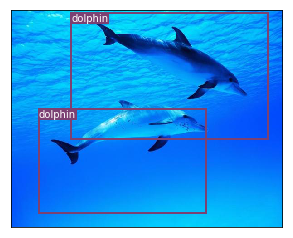

In [179]:
img, _ = valset[Argument_Dict['plot']]
test_img_size = [(img.numpy().shape[1]), (img.numpy().shape[2])]
original_shape = test_img_size
current_dim = 416
orig_w, orig_h = original_shape
print(orig_w)

# new_detections = rescale_boxes(detections_ori, current_dim, test_img_size)
unique_labels = detections_ori[:, -1].cpu().unique()
n_cls_preds = len(unique_labels)
bbox_colors = random.sample(colors, n_cls_preds)

test_path = '../gdrive/My Drive/val_marine.txt'
fff=open(test_path)
lines=fff.readlines()
xxx = lines[Argument_Dict['plot']].strip();
img = np.array(Image.open(xxx))
im = np.array(img)
plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(img)

for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections_ori:
    if cls_conf > Argument_Dict['nms_thres']:
        print("\t+ Label: %s, Conf: %.5f" % (class_names[int(cls_pred)], cls_conf.item()))

        x1 = x1 * orig_w / current_dim
        y1 = y1 * orig_h / current_dim
        x2 = x2 * orig_w / current_dim
        y2 = y2 * orig_h / current_dim
        box_w = x2
        box_h = y2 - y1
        
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]

        # Create a Rectangle patch
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")


        # Add the bbox to the plot
        ax.add_patch(bbox)

        # Add label
        plt.text(
            x1,
            y1,
            s=class_names[int(cls_pred)],
            color="white",
            verticalalignment="top",
            bbox={"color": color, "pad": 0},
        )
plt.gca().xaxis.set_major_locator(NullLocator())
plt.gca().yaxis.set_major_locator(NullLocator())  
# plt.gca().invert_yaxis()
plt.show()  

In [0]:
%matplotlib inline

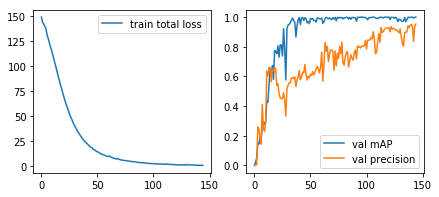

In [180]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
axes[0].plot([x[k] for k in range(len(x))], label = "train total loss")
axes[0].legend(["train total loss"])
axes[1].plot([y[k] for k in range(len(y))], label = "val mAP")
axes[1].plot([z[k] for k in range(len(y))], label = "val precision")
# axes[1].plot([z[k] for k in range(len(z))], label = "val precision")
axes[1].legend(["val mAP", "val precision"])

In [0]:
# #trainset
# # list_path = '../gdrive/My Drive/train_marine.txt'
# # image_path = '../gdrive/My Drive/'
# #valset
# list_path = '../gdrive/My Drive/val_marine.txt'
# image_path = '../gdrive/My Drive/val/'
# import glob

# # path = 'data/'

# def generate_train_and_val(image_path, txt_file):
#     with open(txt_file, 'w') as tf:
#         for jpg_file in glob.glob(image_path + '*.jpg'):
#             tf.write(jpg_file + '\n')
#             print(jpg_file)

# generate_train_and_val(image_path, list_path)
# # generate_train_and_val('data/val/', 'data/val.txt')


In [0]:
# img_size = 224
# transform = tv.transforms.Compose([
#     tv.transforms.Resize((img_size, img_size)),
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
# ])



In [0]:
# class YOLOData(data.Dataset):
#   def __init__(self,
#                  root,
# #                  image_set='train',
#                  transform=None,
#                  target_transform=None):
#   super(VOCDetection, self).__init__(root, transform, target_transform)
#   self.image_set = image_set
  
#   base_dir = '../gdrive/My Drive/'
#   marine_root = os.path.join(self.root, base_dir)
#   image_dir = os.path.join(marine_root, 'JPEGImages')
#   bbox_dir = os.path.join(marine_root, 'Bbox')
  
#   if not os.path.isdir(marine_root):
#            raise RuntimeError('Dataset not found or corrupted.')
      
#   splits_dir = os.path.join(marine_root, 'ImageSets/Segmentation')

#   split_f = os.path.join(splits_dir, image_set.rstrip('\n') + '.txt')


#   def data_pre(self, class_name, data_number, img_size):
#     root = '../gdrive/My Drive/'
#   #   targets = []
#   #   for i in range(data_number):
#     dir_pic = root + class_name + '_' + str(data_number) + '.jpg'
#     dir_txt = root + class_name + '_' + str(data_number) + '.txt'
#     pic_exists = os.path.isfile(dir_pic)
#     txt_exists = os.path.isfile(dir_txt)
#     if pic_exists and txt_exists:
#       img = Image.open(dir_pic)
#       img = transform(img)
#   #       targets = torch.cat((targets, img), 0)
#   #       targets = tf.concat([targets, img], 0)
#   #       img_t = [img_t, img]
#       bbox = get_file(dir_txt, 5)
#   #       targets[i, :] = bbox
#   #       print(dir_txt)
#   #       print(bbox)
#       targets = torch.zeros(len(bbox), 6)
#       targets[:, 1:] = torch.Tensor(bbox)
#       targets[targets != targets] = 0
#   #       print(targets)
#   #       targets = torch.cat((tuple(targets)), 0)
#   #     else:
#   #       continue

#     return img, targets

# #   else:
    
# #     return -1



IndentationError: ignored

In [0]:
# dataset_img = []
# dataset_bbox = []
# x1, y1 = data_pre('dolphin', 1, 224)
# x2, y2 = data_pre('dolphin', 10, 224)
# x3, y3 = data_pre('dolphin', 100, 224)
# # img_targets = torch.cat((x1, x2), 0)
# dataset_img[0] = x1
# dataset_bbox[0] = y1


# root = '../gdrive/My Drive/'
# #   for i in range(data_number):
# data_dir_pic = root + class_name + '_' + str(data_number) + '.jpg'
# data_dir_txt = root + class_name + '_' + str(data_number) + '.txt'
# pic_exists = os.path.isfile(data_dir_pic)
# txt_exists = os.path.isfile(data_dir_txt)
# if pic_exists and txt_exists:
#   for i in range(200):
#     img, bboxy = data_pre('dolphin', i, 224)
#     targets = torch.cat((targets, bbox), 0)


IndexError: ignored